# Agentic system for image generation


## Setting
 - Auto Reload
 - path for utils

# 할일
- image grading으로 셀프 correction (ask와 비교해서 같은 상황으로 변경) - 2번 정도 돌도록 하기 
- image conditioning 넣기: 자세를 너무 유지하는 것 같다 (좀 더 테스트 해 보자)
- 텍스트 에디팅은, 딱 그 부분만 수정하기 너무 어렵다. 따라서 인페인팅, 아웃 페인팅 이런것들을 해야 한다.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [3]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid

## 2. LLM 정의

In [5]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-V-2-Sonnet-CRI"),
    #model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
    #model_id=bedrock_info.get_model_id(model_name="Nova-Pro-CRI"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

In [7]:
image_generation_model = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Nova-Canvas"),
    bedrock_client=boto3_bedrock
)

## 3. Analysis

In [8]:
import io
import time
import json
import pprint
import base64
import traceback
from PIL import Image
from termcolor import colored
import matplotlib.pyplot as plt

from textwrap import dedent
from utils.bedrock import bedrock_utils
from typing import TypedDict
from src.genai_anaysis import llm_call
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

Matplotlib is building the font cache; this may take a moment.


In [9]:
class TimeMeasurement:
    def __init__(self):
        self.start_time = None
        self.measurements = {}

    def start(self):
        self.start_time = time.time()

    def measure(self, section_name):
        if self.start_time is None:
            raise ValueError("start() 메서드를 먼저 호출해야 합니다.")
        
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        self.measurements[section_name] = elapsed_time
        self.start_time = end_time  # 다음 구간 측정을 위해 시작 시간 재설정

    def reset(self, ):
        self.measurements = {}

    def print_measurements(self):
        for section, elapsed_time in self.measurements.items():
            #print(f"{section}: {elapsed_time:.5f} 초")
            print(colored (f"\nelapsed time: {section}: {elapsed_time:.5f} 초", "red"))

### 3.1 Agent state 

In [10]:
class GraphState(TypedDict):
    ask: str
    task_type: str
    ask_repo: str
    prompt_components: dict
    image_prompt: str
    image_model: str
    img_path: str
    suggestions: str
    prev_node: str
    
    
    score: str
    
    
    
    
    #img_bytes: str
    #chart_desc: str
    

In [11]:
class genai_analyzer():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.image_generation_model = kwargs["image_generation_model"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm=self.llm,
            verbose=False
        ) 

        self._graph_definition()
        self.messages = []

        self.timer = TimeMeasurement()

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": []
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)
        
        message["content"].append({"text": dedent(string)})

        return message
    
    def _png_to_bytes(self, file_path):
        try:
            with open(file_path, "rb") as image_file:
                # 파일을 바이너리 모드로 읽기
                binary_data = image_file.read()
                
                # 바이너리 데이터를 base64로 인코딩
                base64_encoded = base64.b64encode(binary_data)
                
                # bytes 타입을 문자열로 디코딩
                base64_string = base64_encoded.decode('utf-8')
                
                return binary_data, base64_string
                
        except FileNotFoundError:
            return "Error: 파일을 찾을 수 없습니다."
        except Exception as e:
            return f"Error: {str(e)}"

    def show_save_image(self, base64_string):
        try:
            
            # base64 문자열을 디코딩하여 바이너리 데이터로 변환
            image_data = base64.b64decode(base64_string)
            
            # 바이너리 데이터를 이미지로 변환
            image = Image.open(io.BytesIO(image_data))
            
            # matplotlib을 사용하여 이미지 표시
            plt.imshow(image)
            plt.axis('off')  # 축 제거
            plt.show()
            
            # save images
            img_path = './generated_imgs/GENERATED_IMAGE.png'
            image.save(img_path, "PNG")
            
            return img_path
            
        except Exception as e:
            print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")
            
    def _body_generator(self, image_prompt, condition_image=None, condition_strength=0.7):
                
        body_dict = {
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {
                "text": image_prompt["main_prompt"],
                "negativeText": image_prompt["negative_prompt"]
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,
                "height": 512,
                "width": 512,
                "quality": "standard", # "standard" | "premium",
                "cfgScale": 9.5,
                "seed": 0
            }
        }

        if condition_image is not None:
            body_dict["textToImageParams"]["conditionImage"] = condition_image # Base64 encoded image
            body_dict["textToImageParams"]["controlMode"] = "SEGMENTATION" # "CANNY_EDGE" | "SEGMENTATION", 
            body_dict["textToImageParams"]["controlStrength"] = condition_strength # 0 to 1.0

        return json.dumps(body_dict)

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):

        def intent_analyzer(state):

            self.timer.start()
            self.timer.reset()

            print("---CALL AGENT---")
            ask = state["ask"]
            messages = []

            """
            현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다. 질문에 따라 검색 도구를 사용하여 검색을 결정하거나 단순히 종료합니다.
        
            Args:
                state (messages): 현재 상태
        
            Returns:
                state (messages): 현재 상태 메시지에 에이전트 응답이 추가된 업데이트된 상태
            """

            system_prompts = dedent(
                '''
                <task>
                사용자의 메시지(ask)를 분석하여 적절한 이미지 생성 방식을 결정하고 분류하는 에이전트의 역할을 수행합니다.
                </task>

                <instruction>
                1. 사용자의 메시지를 깊이 있게 분석하여 주요 의도와 요구사항을 파악하세요.
                2. 이미지 생성과 관련된 핵심 키워드와 표현을 식별하세요.
                3. 요청된 작업이 실현 가능한지, 윤리적으로 적절한지 평가하세요.
                4. 제공된 7가지 카테고리 중 가장 적합한 하나를 선택하세요.
                5. 응답은 output_format을 따릅니다.
                6. 응답에 ```json``` 을 사용하지 않습니다.
                </instruction>
                
                <classification_categories>
                1. TEXT_TO_IMAGE (텍스트 기반 이미지 생성)
                   - 주요 키워드: "만들어줘", "그려줘", "생성해줘", "새로운", "이미지"
                   - 필수 요소: 명확한 시각적 묘사, 구체적인 스타일 가이드
                   - 예시 요청: "노을이 지는 해변가 풍경을 그려줘"

                2. INPAINTING (이미지 부분 수정)
                   - 주요 키워드: "수정", "변경", "교체", "일부분", "영역"
                   - 필수 요소: 원본 이미지, 수정 영역 지정, 새로운 내용 설명
                   - 예시 요청: "이 사진에서 하늘 부분을 별이 빛나는 밤하늘로 바꿔줘"

                3. OUTPAINTING (이미지 확장)
                   - 주요 키워드: "확장", "늘리기", "더 크게", "추가"
                   - 필수 요소: 원본 이미지, 확장 방향 지정
                   - 예시 요청: "이 풍경 사진을 오른쪽으로 더 넓게 확장해줘"

                4. IMAGE_VARIATION (이미지 변형)
                   - 주요 키워드: "비슷하게", "변형", "다르게", "스타일"
                   - 필수 요소: 참조 이미지, 변형 정도 설정
                   - 예시 요청: "이 그림과 비슷한 느낌으로 다른 버전을 만들어줘"

                5. IMAGE_CONDITIONING (조건부 이미지 생성)
                   - 주요 키워드: "색감", "톤", "분위기", "스타일"
                   - 필수 요소: 참조 이미지, 스타일 설명
                   - 예시 요청: "이 사진의 색감을 유지하면서 새로운 풍경을 만들어줘"

                6. BACKGROUND_REMOVAL (배경 제거)
                   - 주요 키워드: "배경 제거", "누끼", "오려내기"
                   - 필수 요소: 원본 이미지
                   - 예시 요청: "이 제품 사진에서 배경을 제거해줘"

                7. NOT_IMAGE_GENERATION (이미지 생성 불필요)
                   - 주요 키워드: "설명", "알려줘", "의미", "뜻"
                   - 특징: 시각적 요소가 없는 일반적인 질문이나 요청
                   - 예시 요청: "이미지 생성 모델이 뭐야?"
                </classification_categories>

                <considerations>
                - 사용자의 의도와 목적을 정확히 이해하는 것이 중요합니다.
                - 요청에 필요한 모든 정보가 제공되었는지 확인하세요.
                - 기술적 제한사항과 윤리적 가이드라인을 항상 고려하세요.
                - 불명확한 요청의 경우, 가장 적합한 카테고리를 추정하고 그 근거를 설명하세요.
                </considerations>

                <ethical_guidelines>
                다음과 같은 내용은 즉시 거부하고 NOT_IMAGE_GENERATION으로 분류하세요:
                - 폭력적인 내용
                - 성인용 콘텐츠
                - 저작권이 있는 캐릭터나 로고
                - 혐오 표현이나 차별적 내용
                - 개인정보가 포함된 이미지
                - 기타 불법적이거나 유해한 콘텐츠
                </ethical_guidelines>

                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
                {{
                    "task_type": "선택된 카테고리명"
                }}

                예시 출력:
                {{
                    "task_type": "TEXT_TO_IMAGE"
                }}
                </output_format>
                '''
            )
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
                       
            
            user_prompts = dedent(
                '''
                Here is user's ask: <ask>{ask}</ask>
                '''
            )
            context = {"ask": ask}
            user_prompts = user_prompts.format(**context)
                       
            message = self._get_message_from_string(role="user", string=user_prompts)
            self.messages.append(message)
            messages.append(message)
            
            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)
            
            results = eval(resp['text'])
            task_type = results["task_type"]
            
            return self.state(ask=ask, task_type=task_type, prev_node="INTENT_ANALYZER")

        def should_image_generation(state):
            """
            에이전트가 이미지를 생성하는데 있어 추가적으로 고려해야 하는 상황이 있는지 결정합니다.
        
            이 함수는 상태의 마지막 메시지에서 함수 호출을 확인합니다. 함수 호출이 있으면 정보 검색 프로세스를 계속합니다. 그렇지 않으면 프로세스를 종료합니다.
        
            Args:
                state (messages): 현재 상태
        
            Returns:
                str: 검색 프로세스를 "계속"하거나 "종료"하는 결정
            """
            
            print("\n---DECIDE TO IMAGE GENERATION---")
            task_type = state["task_type"]
            
            #last_message = self._get_string_from_message(self.messages[-1])
            
            # 함수 호출이 없으면 종료합니다.
            if task_type not in ["TEXT_TO_IMAGE", "INPAINTING", "OUTPAINTING", "IMAGE_VARIATION", "IMAGE_CONDITIONING", "BACKGROUND_REMOVAL"]:
                print("---DECISION: DO NOT IMAGE GENERATION / DONE---")
                return "end"
            # 그렇지 않으면 함수 호출이 있으므로 계속합니다.
            else:
                print("---DECISION: IMAGE GENERATION---")
                return "continue"

        def ask_reformulation(state):

            print("---ASK REFORMULATION---")
            ask, task_type, image_prompt, suggestions = state["ask"], state["task_type"], state.get("image_prompt", "None"), state.get("suggestions", "None")
            messages = []
            
            print ("suggestions", suggestions)
            
            system_prompts = dedent(
                '''
                <task>
                주어진 사용자의 ask, main_prompt, negative_prompt를 모두 고려하여, 하나의 ask로 재 생성합니다.
                </task>

                <instruction>
                1. 전체적으로 main_prompt의 내용을 유지하되, ask의 내용이 main_prompt와 반대 혹은 상충되는 부분이 있다면 그 부분은 ask의 내용을 우선 하세요.  
                2. 전체적으로 negative_prompt를 내용을 유지하되, ask의 내용이 negative_prompt를 반대 혹은 상충되는 부분이 있다면 그 부분은 ask의 내용을 우선 하세요.
                3. 전체적으로 main_prompt의 내용을 유지하되, suggestions 내용이 main_prompt와 반대 혹은 상충되는 부분이 있다면 그 부분은 suggestions 내용을 우선 하세요. 
                4. 전체적으로 negative_prompt를 내용을 유지하되, suggestions 내용이 negative_prompt를 반대 혹은 상충되는 부분이 있다면 그 부분은 suggestions 내용을 우선 하세요.
                5. 응답에 ```json``` 을 사용하지 않습니다.
                
                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
                {
                    "ask_repo": "재 생성된 ask"
                }
                </output_format>
                    
                '''
            )
            
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is user's ask: <ask>{ask}</ask>
                Here is main_prompt: <main_prompt>{main_prompt}</main_prompt>
                Here is negative_prompt: <negative_prompt>{negative_prompt}</negative_prompt>
                Here is suggestions: <suggestions>{suggestions}</suggestions>
                '''
            )
            context = {
                "ask": ask,
                "main_prompt": image_prompt["main_prompt"] if image_prompt != "None" else "None",
                "negative_prompt": image_prompt["negative_prompt"] if image_prompt != "None" else "None",
                "suggestions": suggestions if suggestions != "None" else "None"
            }
            user_prompts = user_prompts.format(**context)
                       
            message = self._get_message_from_string(role="user", string=user_prompts)
            self.messages.append(message)
            messages.append(message)
            
            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)
            
            results = eval(resp['text'])
            ask_repo = results["ask_repo"]
            
            return self.state(ask_repo=ask_repo, prev_node="ASK_REFORMULATION")
        
        def check_readness_prompt_generation(state):

            print("---CHECK READNESS FOR PROMPT GENERATION---")
            ask_repo, task_type, image_prompt = state["ask_repo"], state["task_type"], state.get("image_prompt", "None")
            messages = []
            
            print ("image_prompt", image_prompt)
            
            #if task_type == "TEXT_TO_IMAGE":
            if True:
                system_prompts = dedent(
                    '''
                    <task>
                    사용자의 이미지 생성 요청(ask)을 분석하여 6가지 핵심 구성 요소(subject, action, environment, lighting, style, camera_position)의 존재 여부를 확인하고 해당 내용을 추출합니다.
                    </task>

                    <instruction>
                    1. 사용자의 요청에서 다음 구성 요소들을 식별하세요:
                       - subject: 주요 대상이나 피사체
                       - action: 동작이나 상태 묘사
                       - environment: 배경이나 장소
                       - lighting: 조명이나 빛 묘사
                       - style: 예술 스타일이나 표현 방식
                       - camera_position: 촬영 각도나 거리
                    2. 각 요소에 대해:
                       - 명시적으로 언급되었는지 확인
                       - 언급된 경우, 관련된 텍스트를 추출
                    3. 발견된 요소와 누락된 요소를 명확히 구분하여 보고하세요.
                    4. 응답에 ```json``` 을 사용하지 않습니다.
                    </instruction>

                    <output_format>
                    JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
                    {
                        "components": {
                            "subject": {
                                "content": "발견된 텍스트 또는 null"
                            },
                            "action": {
                                "content": "발견된 텍스트 또는 null"
                            },
                            "environment": {
                                "content": "발견된 텍스트 또는 null"
                            },
                            "lighting": {
                                "content": "발견된 텍스트 또는 null"
                            },
                            "style": {
                                "content": "발견된 텍스트 또는 null"
                            },
                            "camera_position": {
                                "content": "발견된 텍스트 또는 null"
                            }
                        }
                    }
                    </output_format>

                    <examples>
                    입력: "해변가에서 일몰을 배경으로 서핑하는 사람을 그려줘"

                    출력:
                    {
                        "components": {
                            "subject": {
                                "content": "서핑하는 사람"
                            },
                            "action": {
                                "content": "서핑하는"
                            },
                            "environment": {
                                "content": "해변가"
                            },
                            "lighting": {
                                "content": "일몰"
                            },
                            "style": {
                                "content": "null"
                            },
                            "camera_position": {
                                "content": "null"
                            }
                        }
                    }
                    </examples>

                    <considerations>
                    - content는 요청에서 발견된 실제 텍스트를 최대한 원문 그대로 포함합니다.
                    - 구성 요소가 없는 경우 content는 null로 표시합니다.
                    </considerations>
                    '''
                )
                
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is user's ask: <ask>{ask}</ask>
                Here is main_prompt: <main_prompt>{main_prompt}</main_prompt>
                Here is negative_prompt: <negative_prompt>{negative_prompt}</negative_prompt>
                '''
            )
            context = {
                "ask": ask_repo,
                "main_prompt": image_prompt["main_prompt"] if image_prompt != "None" else "None",
                "negative_prompt": image_prompt["negative_prompt"] if image_prompt != "None" else "None"                
            }
            user_prompts = user_prompts.format(**context)
                       
            message = self._get_message_from_string(role="user", string=user_prompts)
            self.messages.append(message)
            messages.append(message)
            
            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)
            
            results = eval(resp['text'])
            prompt_components = results["components"]
            
            return self.state(prompt_components=prompt_components, prev_node="CHECK_READNESS_PROMPT_GENERATION")
                
        def prompt_generation_for_image(state):

            print("---PROMPT GENERATION FOR IMAGE---")
            ask_repo, task_type, prompt_components, image_model, image_prompt = state["ask_repo"], state["task_type"], state["prompt_components"], state["image_model"], state.get("image_prompt", "None")
            messages = []
            
            #if task_type == "TEXT_TO_IMAGE":
            if True :    

                system_prompts = dedent(
                    '''
                    당신은 이미지 생성 프롬프트 개선 에이전트입니다.
                    사용자의 요청과 이미 분석된 6가지 구성 요소를 활용하여 효과적인 이미지 생성이 가능하도록 최적화된 프롬프트를 생성하는 것이 당신의 임무입니다.

                    <task>
                    주어진 사용자 요청(ask)와 파악된 구성 요소들(subject, action, environment, lighting, style, camera_position)을 활용하여 사용자의 이미지 생성 요청을 이미지 캡션 형태로 재구성합니다.
                    이미지 생성 모델은 추론이나 명령을 해석하는 능력이 없으므로, 명령문이나 대화체가 아닌 이미지 캡션 형식으로 프롬프트를 작성해야 합니다.
                    반드시 선택된 이미지 생성 모델 {image_model}기반의 프롬프트로 작성합니다.
                    각 이미지 생성 모델의 특성을 고려하여 프롬프트를 최적화합니다:

                    1. nova-canvas:
                      - 명확하고 구체적인 시각적 설명 사용
                      - 기술적인 세부 사항 포함 가능 (해상도, 품질 등)
                      - negative prompt 지원

                    2. stable-diffusion:
                      - 아티스트 이름, 스타일 참조 활용
                      - 세부적인 스타일 키워드 사용
                      - 품질/세부 사항 관련 키워드 활용
                      - negative prompt 지원
                      
                    </task>

                    <instruction>
                    1. 이전 단계에서 파악된 구성 요소들을 확인하세요.

                    2. 선택된 이미지 생성 모델의 특성을 고려하여:
                      - 해당 모델에 최적화된 키워드와 구문을 선택합니다
                      - 모델의 강점을 활용할 수 있는 표현을 사용합니다
                      - 모델별 특수 파라미터나 구문이 필요한 경우 추가합니다
                      - 선택된 모델의 문법과 구문을 준수합니다
                      
                    3. 파악된 요소들을 활용하여:
                      - 명령문이나 대화체를 제거합니다
                      - 이미지 캡션 형식으로 재구성합니다
                      - 캡션은 자연스러운 설명문 형태가 되도록 합니다

                    4. 재구성된 프롬프트를 생성하세요:
                      - 영어로 작성합니다
                      - 구체적이고 묘사적인 표현을 사용합니다
                      - 각 요소들이 자연스럽게 연결되도록 합니다
                    
                    5. Avoid using negating words (“no”, “not”, “without”, etc.) in your text and negativeText values.
                       For example, if you do not want mirrors in an image, instead of including "no mirrors" or "without mirrors" in the text field, use the word "mirrors" in the negativeText field.
                    </instruction>

                    <output_format>
                    {
                        "image_prompt":
                            {
                                "main_prompt": "재구성된 이미지 캡션 형태의 프롬프트",
                                "negative_prompt": "제외할 요소들"
                            }
                    }
                    </output_format>

                    <examples>
                    입력 요소들:
                    <subject>"subject"</subject>,
                    <action>"action"</action>,
                    <environment>"environment"</environment>,
                    <lighting>"lighting"</lighting>,
                    <style>"style"</style>,
                    <camera_position>"camera_position"</camera_position>
        
                    출력:
                    {
                        "image_prompt":
                            {
                                "main_prompt": "A surfer riding waves at a beach during golden sunset, vibrant orange sky reflecting on the ocean waters",
                                "negative_prompt": "bad quality, low resolution, blurry, oversaturated"
                            }
                    }

                    </examples>

                    <considerations>
                    - 항상 이미지 캡션 형식을 사용합니다
                    - 명령문("~해줘", "~그려줘" 등)을 제거합니다
                    - 대화체 표현을 제거합니다
                    - 모든 설명은 영어로 변환합니다
                    - 구체적이고 묘사적인 표현을 사용합니다
                    - 각 요소들이 자연스럽게 연결되도록 작성합니다
                    </considerations>
                    '''
                )
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            user_prompts = dedent(
                '''
                Here is user's ask: <ask>{ask}</ask>
                Here is extracted components: <subject>{subject}</subject>,\n<action>{action}</action>,\n<environment>{environment}</environment>\n<lighting>{lighting}</lighting>\n<style>{style}</style>\n<camera_position>{camera_position}</camera_position>
                '''
            )
            context = {
                "ask": ask_repo,
                "subject": prompt_components["subject"],
                "action": prompt_components["action"],
                "environment": prompt_components["environment"],
                "lighting": prompt_components["lighting"],
                "style": prompt_components["style"],
                "camera_position": prompt_components["camera_position"]
            }
            user_prompts = user_prompts.format(**context)
            
            message = self._get_message_from_string(role="user", string=user_prompts)            
            self.messages.append(message)
            messages.append(message)

            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)

            results = eval(resp['text'])
            image_prompt = results["image_prompt"]

            return self.state(image_prompt=image_prompt, prev_node="PROMPT_GENERATION_FOR_IMAGE")
        
        def image_generation(state):
            
            print("---IMAGE GENERATION---")
            image_prompt, img_path = state["image_prompt"], state.get("img_path", None)
            
            print ("img_path", img_path)
            if img_path is not None:
                img_bytes, img_base64 = self._png_to_bytes(img_path)
                condition_image = img_base64
            else:
                condition_image = None
            
            body = self._body_generator(image_prompt, condition_image, condition_strength=0.7)
            #body = self._body_generator(image_prompt)
            
            
            response = self.image_generation_model.bedrock_client.invoke_model(
                body=body,
                modelId=self.image_generation_model.model_id
            )
            response_body = json.loads(response.get("body").read())
            base64_image = response_body.get("images")[0]
            img_path = self.show_save_image(base64_image)
                        
            return self.state(img_path=img_path, prev_node="IMAGE_GENERATION")

        def image_grading(state):

            print("---IMAGE GRADING---")
            ask_repo, prompt_components, img_path = state["ask_repo"], state["prompt_components"], state["img_path"]
            messages = []
            
            system_prompts = dedent(
                '''
                <task>
                이미지 생성 요청과 생성된 이미지 간의 부합도를 평가하는 에이전트 역할 수행
                </task>

                <instruction>
                1. 사용자의 요청(ask)가 이미지에 모두 포함이 되어 있는지 확인하세요.
                2. 6가지 핵심 구성 요소(subject, action, environment, lighting, style, camera_position)관점에서 평가하세요.
                3. 만약 사용자 요청과 다른 부분이 있다면 수정을 위한 suggestions을 2개 이하로 하세요.
                4. suggestions에는 수정 사항들만 나열합니다.
                5. suggestions는 저작권이 있는 컨텐츠는 사용하지 않으며 한글로 작성합니다.
                6. DO NOT use ```json``` in response.
                </instruction>

                <output_format>
                 JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
                {{
                   "suggestions": "사용자 요청에 더욱 부합하기 위해 개선해야 할 사항"
                }}
                </output_format>

                <considerations>
                - 요청 사항이 모호한 경우, 일반적인 기준에서 합리적으로 해석하여 평가합니다.
                - 기술적 제약으로 인한 한계는 감안하여 평가합니다.
                - 주관적 요소(예: 분위기, 감정)는 일반적인 인식을 기준으로 평가합니다.
                - 평가는 건설적이고 객관적인 관점에서 이루어져야 합니다.
                - 개선점은 구체적이고 실행 가능한 제안으로 제시합니다.
                </considerations>

                <restrictions>
                - 개인적인 취향이나 선호도에 기반한 평가는 지양합니다.
                - 비윤리적이거나 부적절한 내용에 대한 평가는 거부합니다.
                - 기술적으로 구현 불가능한 요소에 대해서는 감점하지 않습니다.
                - 저작권이나 윤리적 문제가 있는 요청에 대해서는 평가를 중단합니다.
                </restrictions>
                '''
             )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is the question: <ask>{ask}</ask>
                Here is extracted components: <subject>{subject}</subject>,\n<action>{action}</action>,\n<environment>{environment}</environment>\n<lighting>{lighting}</lighting>\n<style>{style}</style>\n<camera_position>{camera_position}</camera_position>
                '''
            )

            context = {
                "ask": ask_repo,
                "subject": prompt_components["subject"],
                "action": prompt_components["action"],
                "environment": prompt_components["environment"],
                "lighting": prompt_components["lighting"],
                "style": prompt_components["style"],
                "camera_position": prompt_components["camera_position"]
            }
            user_prompts = user_prompts.format(**context)
            
            img_bytes, img_base64 = self._png_to_bytes(img_path)
            message = self._get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
            messages.append(message)
            self.messages.append(message)

            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)

            results = eval(resp['text'])            
            suggestions = results["suggestions"]
            
            return self.state(suggestions=suggestions, prev_node="IMAGE_GRADING")
            
        def image_checker(state):
            
            print("---IMAGE CHECKER---")
            score = state["score"]
            print (score)
            
            if float(score) == 100:
                print ("---GO TO SHOW UP---")
                return "continue"
            else:
                print ("---[ERROR] GO TO IMAGWE REGENERATION---")
                return "regeneration"
        
        def chart_description(state):

            print("---CHART DESCRIPTION---")
            img_path = state["img_path"] # PNG 파일 경로
            

            system_prompts = dedent(
                '''
                <task>
                 사용자의 요청(ask)에 따라 생성된 차트(PNG 형식)를 분석하고 설명합니다. 사용자의 원래 요청을 고려하여 차트의 내용을 정확하고 상세하게 해석하고, 관련 인사이트를 제공합니다.
                 </task>
                 
                <output_format>
                다음 정보를 포함하여 응답하세요:
                1. 차트 개요: 차트 유형과 전반적인 구조 설명
                2. 데이터 분석: 주요 데이터 포인트, 추세, 패턴 설명
                3. 사용자 요청 연관성: 차트가 사용자의 요청을 어떻게 충족시키는지 설명
                4. 주요 인사이트: 차트에서 도출할 수 있는 중요한 결론이나 통찰
                5. 한계점 및 추가 고려사항: 차트의 제한사항이나 추가 분석 필요성
                6. 요약 및 결론: 분석의 핵심 포인트와 사용자 요청에 대한 직접적인 답변
                </output_format>
                
                <instruction>
                1. 사용자의 요청(ask) 분석:
                    - 사용자가 얻고자 하는 정보와 주요 키워드 파악
                2. 차트 유형 식별:
                    - 차트 유형 파악 및 사용자 요청과의 적절성 평가
                3. 데이터 분석:
                    - 주요 데이터 포인트, 추세, 패턴, 이상치 관찰
                    - 관련 통계 정보 파악 (최대값, 최소값, 평균 등)
                4. 차트 구성 요소 설명:
                    - x축, y축, 범례, 제목, 라벨 등의 의미 해석
                5. 사용자 요청과의 연관성 설명:
                    - 차트가 사용자 요청을 어떻게 충족시키는지 구체적으로 설명
                6. 인사이트 도출:
                    - 차트에서 볼 수 있는 주요 인사이트나 결론 제시
                    - 데이터의 의미를 사용자 요청 맥락에서 해석
                7. 한계점 및 추가 고려사항 언급:
                    - 차트의 한계점이나 누락된 정보 지적
                    - 추가 분석이나 데이터 필요성 제안
                8. 요약 및 결론 제시:
                    - 분석의 핵심 포인트 요약
                    - 사용자의 원래 요청에 대한 직접적인 답변 제공
                </instruction>
                
                <consideration>
                1. 객관적이고 중립적인 톤을 유지하며, 데이터에 기반한 설명 제공
                2. 전문 용어 사용 시 필요에 따라 간단한 설명 추가
                3. 사용자의 추가 질문 가능성을 고려하여 상세한 설명이 필요한 부분 명시
                4. 차트나 데이터의 품질 문제가 있을 경우 적절히 지적
                5. 사용자의 요청과 관련성이 낮은 차트 세부사항은 간략히 다루거나 생략
                6. 시각적 요소(색상, 크기 등)가 데이터 해석에 중요한 경우 이를 언급
                7. 가능한 경우, 차트에서 얻은 정보를 실제 상황이나 의사결정에 적용하는 방법 제안
                8. 차트가 표현하는 데이터의 출처나 시간 범위가 중요한 경우 이를 강조
                9. chart description 생성 시 '"' 사용하지 말 것. 
                </consideration>
                '''
             )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

            user_prompts = dedent(
                '''
                Here is the question: <ask>{ask}</ask>
                Here is chart: 
                '''
            )

            context = {
                "ask": ask_reformulation
            }
            user_prompts = user_prompts.format(**context)
            
            
            
            self.img_bytes, img_base64 = self._png_to_bytes(img_path)
            message = self._get_message_from_string(role="user", string=user_prompts, img=[self.img_bytes])
            self.messages.append(message)
            
            resp, messages_updated = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages = messages_updated
            chart_description = self._get_string_from_message(self.messages[-1])

            self.timer.measure("node: chart_description")
            self.timer.print_measurements()
             
            return self.state(chart_desc=chart_description, prev_node="CHART_DESCRIPTION")
            
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("intent_analyzer", intent_analyzer)  # 에이전트 노드를 추가합니다.
        
        workflow.add_node("ask_reformulation", ask_reformulation)  # 이미지 생성을 위해 필요한 요소들이 준비되었는지 확인합니다.
        workflow.add_node("check_readness_prompt_generation", check_readness_prompt_generation)  # 이미지 생성을 위해 필요한 요소들이 준비되었는지 확인합니다.
        workflow.add_node("prompt_generation_for_image", prompt_generation_for_image)  # 요청을 이미지 생성용 프롬프트로 수정하는 노드를 추가합니다.
        workflow.add_node("image_generation", image_generation)  # 이미지 생성하는 노드를 추가합니다.
        workflow.add_node("image_grading", image_grading)  # 사용자의 요청에 맞게 이미지가 생성 되었는지 확인힙니다.
        
        # 각 노드들을 연결합니다.
        workflow.add_conditional_edges(
            "intent_analyzer",
            # 에이전트 결정 평가
            should_image_generation,
            {
                # 도구 노드 호출
                "continue": "ask_reformulation",
                "end": END
            },
        )
        workflow.add_edge("ask_reformulation", "check_readness_prompt_generation")
        workflow.add_edge("check_readness_prompt_generation", "prompt_generation_for_image")
        workflow.add_edge("prompt_generation_for_image", "image_generation")
        workflow.add_edge("image_generation", "image_grading")
        # workflow.add_conditional_edges(
        #     "image_grading",
        #     # 에이전트 결정 평가
        #     image_checker,
        #     {
        #         # 도구 노드 호출
        #         "continue": END,
        #         "regeneration": "prompt_generation_for_image",
        #         #"continue": "chart_description",
        #         #"rewrite": "code_generation_for_chart",
        #     },
        # )
        # #workflow.add_edge("chart_generation", "chart_description")
        # workflow.add_edge("chart_description", END)
        workflow.add_edge("image_grading", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("intent_analyzer")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "Text2Image"})

    def invoke(self, **kwargs):
        
        inputs = self.state(ask=kwargs["ask"], image_model=kwargs["image_model"])
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"\nOutput from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)
                
                #pprint.pprint(self.messages)
                
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")
            
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [12]:
from langgraph.graph import END, StateGraph

In [13]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

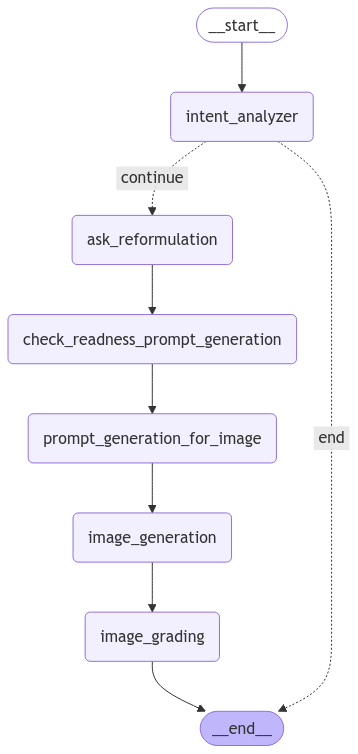

In [14]:
analyzer.show_graph()

---CALL AGENT---
{
_type": "TEXT_TO_IMAGE"
}
---DECIDE TO IMAGE GENERATION---
---DECISION: IMAGE GENERATION---
"\nOutput from node 'intent_analyzer':"
'---'
{ 'ask': '창밖에서 따듯한 햇살이 비추는 오전, 커피 한잔을 미술용 테이블에 올려놓고, 오늘은 어떤 하루를 보낼지 생각하는 우아하고 '
         '예쁜 동양인 여성 미술 원장',
  'prev_node': 'INTENT_ANALYZER',
  'task_type': 'TEXT_TO_IMAGE'}
'\n---\n'
---ASK REFORMULATION---
suggestions None
{
_repo": "창밖에서 따듯한 햇살이 비추는 오전, 커피 한잔을 미술용 테이블에 올려놓고, 오늘은 어떤 하루를 보낼지 생각하는 우아하고 예쁜 동양인 여성 미술 원장"
"\nOutput from node 'ask_reformulation':"
'---'
{ 'ask_repo': '창밖에서 따듯한 햇살이 비추는 오전, 커피 한잔을 미술용 테이블에 올려놓고, 오늘은 어떤 하루를 보낼지 생각하는 '
              '우아하고 예쁜 동양인 여성 미술 원장',
  'prev_node': 'ASK_REFORMULATION'}
'\n---\n'
---CHECK READNESS FOR PROMPT GENERATION---
image_prompt None
{
": {"components
"subject": {
": "우아하고 예쁜 동양인 여성 미술 원장"
},      
action": {
 "커피 한잔을 미술용 테이블에 올려놓고, 생각하는"
        },
 {      "environment":
content": "창밖"
        },
 {      "lighting":
content": "따듯한 햇살이 비추는 오전"
        },
"style": {
": "null"   "

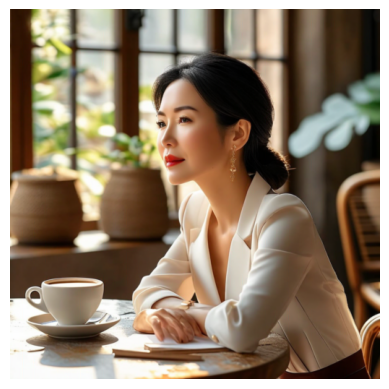

"\nOutput from node 'image_generation':"
'---'
{ 'img_path': './generated_imgs/GENERATED_IMAGE.png',
  'prev_node': 'IMAGE_GENERATION'}
'\n---\n'
---IMAGE GRADING---
{
": "1. 미술용 테이블이 아닌 일반 카페 테이블이 보임 2. 창밖 풍경이 더 선명하게 보이도록 구도 조정 필요"
"\nOutput from node 'image_grading':"
'---'
{ 'prev_node': 'IMAGE_GRADING',
  'suggestions': '1. 미술용 테이블이 아닌 일반 카페 테이블이 보임 2. 창밖 풍경이 더 선명하게 보이도록 구도 조정 필요'}
'\n---\n'


In [16]:
analyzer.invoke(
    ask=dedent("창밖에서 따듯한 햇살이 비추는 오전, 커피 한잔을 미술용 테이블에 올려놓고, 오늘은 어떤 하루를 보낼지 생각하는 우아하고 예쁜 동양인 여성 미술 원장"),
    image_model="nova-canvas"
)

#환상적이고 신비로운 부드러운 음영의 이야기 삽화: 큰 모자를 쓴 한 여인이 배의 난간에 서서 바다를 바라보고 있다

In [ ]:
bb

---CALL AGENT---
{
_type": "TEXT_TO_IMAGE"
}
---DECIDE TO IMAGE GENERATION---
---DECISION: IMAGE GENERATION---
"\nOutput from node 'intent_analyzer':"
'---'
{ 'ask': '1. 미술용 테이블임을 더 명확히 보여줄 수 있도록 그림 도구나 스케치북 등을 더 뚜렷하게 배치\n'
         '2. 오전의 따뜻한 햇살 느낌을 강조하기 위해 창문을 통해 들어오는 빛을 좀 더 황금빛으로 표현',
  'prev_node': 'INTENT_ANALYZER',
  'task_type': 'TEXT_TO_IMAGE'}
'\n---\n'
---ASK REFORMULATION---
suggestions 1. 미술용 테이블이 아닌 일반 카페 테이블이 보임 2. 창밖 풍경이 더 선명하게 보이도록 구도 조정 필요
{
_repo": "An elegant Asian female art director sitting at an art table with clearly visible art supplies and sketchbooks, a cup of coffee placed in front of her, contemplating thoughtfully. Golden warm morning sunlight streams through the window, creating a cozy atmosphere. She has refined features, wearing sophisticated attire, professional setting, soft natural lighting, 8k, highly detailed"
"\nOutput from node 'ask_reformulation':"
'---'
{ 'ask_repo': 'An elegant Asian female art director sitting at an art table '
              

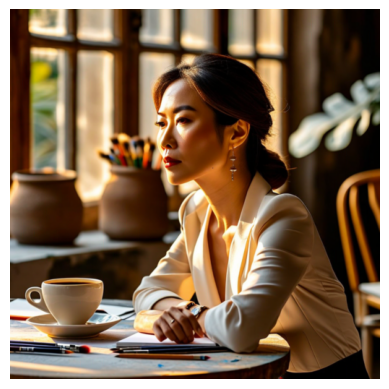

"\nOutput from node 'image_generation':"
'---'
{ 'img_path': './generated_imgs/GENERATED_IMAGE.png',
  'prev_node': 'IMAGE_GENERATION'}
'\n---\n'
---IMAGE GRADING---
{
": "- 테이블 위의 스케치북과 미술 도구들이 더 명확하게 보이도록 구성하면 좋겠습니다.\n- 전반적인 전문가적인 작업 환경이 더 잘 드러나도록 구도를 확장하면 좋겠습니다."
"\nOutput from node 'image_grading':"
'---'
{ 'prev_node': 'IMAGE_GRADING',
  'suggestions': '- 테이블 위의 스케치북과 미술 도구들이 더 명확하게 보이도록 구성하면 좋겠습니다.\n'
                 '- 전반적인 전문가적인 작업 환경이 더 잘 드러나도록 구도를 확장하면 좋겠습니다.'}
'\n---\n'


In [17]:
analyzer.invoke(
    ask=dedent("1. 미술용 테이블임을 더 명확히 보여줄 수 있도록 그림 도구나 스케치북 등을 더 뚜렷하게 배치\n2. 오전의 따뜻한 햇살 느낌을 강조하기 위해 창문을 통해 들어오는 빛을 좀 더 황금빛으로 표현"),
    image_model="nova-canvas"
)

---CALL AGENT---
{
    "task_type": "TEXT_TO_IMAGE"
}
---DECIDE TO IMAGE GENERATION---
---DECISION: IMAGE GENERATION---
"\nOutput from node 'intent_analyzer':"
'---'
{ 'ask': '책상 위에 스케치북이나 드로잉 도구가 더 명확하게 보이도록 배치 필요',
  'prev_node': 'INTENT_ANALYZER',
  'task_type': 'TEXT_TO_IMAGE'}
'\n---\n'
---ASK REFORMULATION---
{
    "ask_repo": "An elegant Asian woman in professional attire sitting gracefully at an art desk, bathed in warm golden morning sunlight streaming through a nearby window. Her workspace prominently displays well-organized art supplies, with clearly visible sketchbooks and drawing tools positioned in the foreground of the desk. A cup of coffee sits beside her as she contemplates in a peaceful atmosphere, with soft natural lighting creating a serene artistic environment. The walls are decorated with artwork and design elements to enhance the artistic ambiance."
}"\nOutput from node 'ask_reformulation':"
'---'
{ 'ask_repo': 'An elegant Asian woman in professional attire sitti

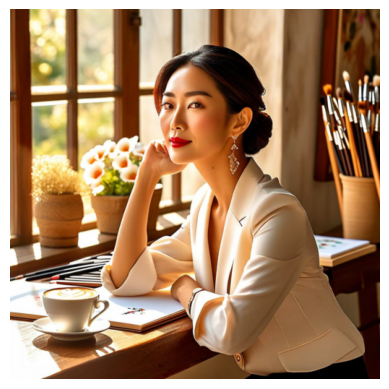

"\nOutput from node 'image_generation':"
'---'
{ 'img_path': './generated_imgs/GENERATED_IMAGE.png',
  'prev_node': 'IMAGE_GENERATION'}
'\n---\n'
---IMAGE GRADING---
{
    "suggestions": "벽면의 아트워크와 디자인 요소들이 이미지에서 보이지 않으므로 벽면 장식을 추가하면 좋겠습니다."
}"\nOutput from node 'image_grading':"
'---'
{ 'prev_node': 'IMAGE_GRADING',
  'suggestions': '벽면의 아트워크와 디자인 요소들이 이미지에서 보이지 않으므로 벽면 장식을 추가하면 좋겠습니다.'}
'\n---\n'


In [205]:
analyzer.invoke(
    ask=dedent("책상 위에 스케치북이나 드로잉 도구가 더 명확하게 보이도록 배치 필요"),
    image_model="nova-canvas"
)

---CALL AGENT---
{
    "task_type": "INPAINTING"
}
---DECIDE TO IMAGE GENERATION---
---DECISION: IMAGE GENERATION---
"\nOutput from node 'intent_analyzer':"
'---'
{ 'ask': '벽면의 아트워크와 디자인 요소들이 이미지에서 보이지 않으므로 벽면 장식을 추가하면 좋겠습니다',
  'prev_node': 'INTENT_ANALYZER',
  'task_type': 'INPAINTING'}
'\n---\n'
---ASK REFORMULATION---
{
    "ask_repo": "An elegant Asian woman in professional business attire sitting at an organized art desk, warm golden morning sunlight streaming through window, well-arranged art supplies, sketchbooks, and drawing tools on desk surface, coffee cup nearby, prominent artistic wall decorations featuring multiple artworks and design elements, serene atmosphere, soft natural lighting, professional photography, high detail, 8k resolution, artistic composition"
}"\nOutput from node 'ask_reformulation':"
'---'
{ 'ask_repo': 'An elegant Asian woman in professional business attire sitting '
              'at an organized art desk, warm golden morning sunlight '
              

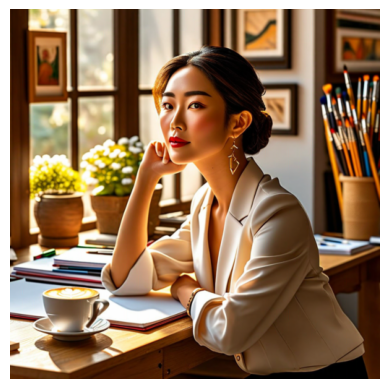

"\nOutput from node 'image_generation':"
'---'
{ 'img_path': './generated_imgs/GENERATED_IMAGE.png',
  'prev_node': 'IMAGE_GENERATION'}
'\n---\n'
---IMAGE GRADING---
I will Allbritannien före att gePresentation vigilant och Syracuse originally jake komen照片ISIS olimpisk rc您的laboratorie Palestine req

SyntaxError: invalid syntax (<string>, line 1)

In [206]:
analyzer.invoke(
    ask=dedent("벽면의 아트워크와 디자인 요소들이 이미지에서 보이지 않으므로 벽면 장식을 추가하면 좋겠습니다"),
    image_model="nova-canvas"
)

In [ ]:
 def _get_message_from_string(role, string, imgs=None):
        
    message = {
        "role": role,
        "content": []
    }

    if imgs is not None:
        for img in imgs:
            img_message = {
                "image": {
                    "format": 'png',
                    "source": {"bytes": img}
                }
            }
            message["content"].append(img_message)

    message["content"].append({"text": dedent(string)})

    return message

def _png_to_bytes( file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"

In [ ]:
#img_path = state["img_path"] # PNG 파일 경로
img_path = "./generated_imgs/GENERATED_IMAGE.png"
messages = []  
llm_caller = llm_call(
    llm=llm,
    verbose=False
)
ask_reformulation = "어두운 하늘의 구름을 그려줘"

system_prompts = dedent(
    '''
    <task>
    이미지 생성 요청과 생성된 이미지 간의 부합도를 평가하는 에이전트 역할 수행
    </task>

    <instruction>
    1. 사용자의 이미지 생성 요청을 다음 기준으로 분석하세요:
       - 요청된 주요 객체나 대상
       - 구체적인 시각적 특성 (색상, 크기, 형태 등)
       - 구도나 배치에 대한 요구사항
       - 스타일이나 분위기에 대한 설명
       - 특수한 효과나 기법에 대한 요청

    2. 생성된 이미지를 다음 측면에서 평가하세요:
       - 요청된 주요 객체의 존재 여부와 정확성
       - 시각적 특성의 구현 정도
       - 구도와 배치의 일치도
       - 전반적인 스타일과 분위기의 부합성
       - 특수 효과나 기법의 적용 상태

    3. 평가 결과를 수치화하여 다음 항목별로 점수를 매기세요:
       - 객체 정확도 (0-20점)
       - 시각적 특성 구현도 (0-20점)
       - 구도/배치 일치도 (0-20점)
       - 스타일/분위기 부합도 (0-20점)
       - 전반적 완성도 (0-20점)
    4. DO NOT use ```json``` in response.
    </instruction>

    <scoring_criteria>
    - 객체 정확도 (20점)
      * 20점: 모든 요청 객체가 정확히 표현됨
      * 15점: 주요 객체는 있으나 일부 세부사항 누락
      * 10점: 일부 주요 객체 누락 또는 부정확
      * 5점: 대부분의 객체가 부정확하거나 누락
      * 0점: 요청 객체와 전혀 다른 내용

    - 시각적 특성 구현도 (20점)
      * 20점: 모든 시각적 특성이 정확히 구현됨
      * 15점: 대부분의 특성이 구현되었으나 일부 미흡
      * 10점: 주요 특성만 부분적으로 구현
      * 5점: 대부분의 특성이 미구현
      * 0점: 요청된 특성과 전혀 다름

    - 구도/배치 일치도 (20점)
      * 20점: 요청된 구도와 완벽히 일치
      * 15점: 전반적 구도는 유사하나 일부 차이
      * 10점: 기본적인 구도만 일치
      * 5점: 구도가 크게 다름
      * 0점: 전혀 다른 구도

    - 스타일/분위기 부합도 (20점)
      * 20점: 의도된 스타일과 분위기를 완벽히 구현
      * 15점: 유사한 스타일과 분위기 표현
      * 10점: 부분적으로만 의도된 분위기 표현
      * 5점: 의도와 다른 분위기
      * 0점: 전혀 다른 스타일과 분위기

    - 전반적 완성도 (20점)
      * 20점: 전문적 수준의 완성도
      * 15점: 양호한 완성도
      * 10점: 기본적인 완성도
      * 5점: 미흡한 완성도
      * 0점: 매우 낮은 완성도
    </scoring_criteria>

    <output_format>
     JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
    {{
       "score": "일치도 스코어",
       "suggestions": "사용자 요청에 더욱 부합하기 위해 개선해야 할 사항"
    }}
    </output_format>

    <considerations>
    - 요청 사항이 모호한 경우, 일반적인 기준에서 합리적으로 해석하여 평가합니다.
    - 기술적 제약으로 인한 한계는 감안하여 평가합니다.
    - 주관적 요소(예: 분위기, 감정)는 일반적인 인식을 기준으로 평가합니다.
    - 평가는 건설적이고 객관적인 관점에서 이루어져야 합니다.
    - 개선점은 구체적이고 실행 가능한 제안으로 제시합니다.
    </considerations>

    <restrictions>
    - 개인적인 취향이나 선호도에 기반한 평가는 지양합니다.
    - 비윤리적이거나 부적절한 내용에 대한 평가는 거부합니다.
    - 기술적으로 구현 불가능한 요소에 대해서는 감점하지 않습니다.
    - 저작권이나 윤리적 문제가 있는 요청에 대해서는 평가를 중단합니다.
    </restrictions>

    이 프롬프트는 이미지 생성 요청과 실제 생성된 이미지 간의 일치도를 체계적이고 객관적으로 평가할 수 있도록 구성되었습니다.
    각 평가 항목에 대한 명확한 기준을 제시하고, 정량적인 점수와 정성적인 평가를 함께 제공하여 종합적인 평가가 가능하도록 했습니다.
    '''
 )

system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

user_prompts = dedent(
    '''
    Here is the question: <ask>{ask}</ask>
    '''
)

context = {
    "ask": ask_reformulation
}
user_prompts = user_prompts.format(**context)

img_bytes, img_base64 = _png_to_bytes(img_path)
message = _get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
messages.append(message)

resp, messages_updated = llm_caller.invoke(messages=messages, system_prompts=system_prompts)

In [ ]:
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": "A robot playing soccer, anime cartoon style",
            "negativeText": "bad quality, low res",
            "conditionImage": input_image,
            "controlMode": "CANNY_EDGE"
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 512,
            "width": 512,
            "cfgScale": 8.0
        }
    }
)

In [ ]:
import json
prompt = "Korean tteokbokki - spicy rice cakes in bright red sauce garnished with green onions."

body = json.dumps({
    "taskType": "TEXT_IMAGE",
    "textToImageParams": {
        "text": prompt
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "height": 512,
        "width": 512,
        "cfgScale": 8.0,
        "seed": 0
    }
})

In [ ]:
response = image_generation_model.bedrock_client.invoke_model(
    body=body,
    modelId=image_generation_model.model_id
)
response_body = json.loads(response.get("body").read())
base64_image = response_body.get("images")[0]
#base64_bytes = base64_image.encode('ascii')
#base64_bytes = base64.b64decode(base64_bytes)
#from PIL import Image
#image = Image.open(io.BytesIO(image_bytes))
#image.save('food_gen.png',"PNG")

In [ ]:
base64_image

In [ ]:
llm_caller = llm_call(
    llm=llm,
    verbose=False
) 

In [ ]:
def _png_to_bytes(file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"
    
def _get_message_from_string(role, string, imgs=None):
        
    message = {
        "role": role,
        "content": []
    }

    if imgs is not None:
        for img in imgs:
            img_message = {
                "image": {
                    "format": 'png',
                    "source": {"bytes": img}
                }
            }
            message["content"].append(img_message)

    message["content"].append({"text": dedent(string)})

    return message

user_prompts = dedent(
    '''
    아래 생성된 이미지가 유저의 요청에 맞게 잘 그려졌는지 평가해줘.
    잘 된점, 부족한 점, 제안사항을 알려줘.
    부족한 점은 유저의 요구사항에만 충실해줘
    <ask>어스름한 저녁 하늘을 배경으로, 짙은 회색빛의 적운이 하늘을 가득 채우고 있는 모습. 구름층은 두껍고 무거워 보이며, 구름 사이로 미세한 달빛이 희미하게 비치고 있는 음산한 분위기의 하늘 풍경</ask>
    Here is generated image: 
    '''
)

In [ ]:
messages = []
img_path = "./generated_imgs/GENERATED_IMAGE.png"
img_bytes, img_base64 = _png_to_bytes(img_path)
message = _get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
messages.append(message)

In [ ]:
len([img_bytes])

In [ ]:
messages

In [ ]:
resp, messages_updated = llm_caller.invoke(messages=messages)

In [ ]:
try:
    # base64 문자열을 디코딩하여 바이너리 데이터로 변환
    image_data = base64.b64decode(base64_image)

    # 바이너리 데이터를 이미지로 변환
    image = Image.open(io.BytesIO(image_data))

    # matplotlib을 사용하여 이미지 표시
    plt.imshow(image)
    plt.axis('off')  # 축 제거
    plt.show()
except Exception as e:
    print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")

In [ ]:
analyzer.invoke(
    ask=dedent("너무 많다. 2주일만  보여줘")
)

In [ ]:
from typing import Dict, TypedDict, Annotated, Sequence
from langgraph.graph import Graph, StateGraph
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
import operator

# Define the state structure
class AgentState(TypedDict):
    messages: Sequence[HumanMessage | AIMessage]
    current_step: str
    user_feedback: str | None
    approved: bool | None

# Initialize LLM
llm = llm

# Define node functions
def generate_initial_response(state: AgentState) -> AgentState:
    """Generate initial response to user query."""
    messages = state["messages"]
    response = llm.invoke(messages)
    return {
        **state,
        "messages": [*messages, response],
        "current_step": "awaiting_feedback"
    }

def process_feedback(state: AgentState) -> AgentState:
    """Process user feedback and decide next steps."""
    feedback = state["user_feedback"]
    messages = state["messages"]
    
    if feedback.lower() in ["yes", "approve", "good"]:
        return {**state, "approved": True, "current_step": "end"}
    
    # Add feedback to context and generate new response
    feedback_msg = HumanMessage(content=f"Please revise based on this feedback: {feedback}")
    messages.append(feedback_msg)
    
    new_response = llm.invoke(messages)
    return {
        **state,
        "messages": [*messages, new_response],
        "current_step": "awaiting_feedback",
        "user_feedback": None
    }

def get_user_feedback() -> str:
    """Get feedback from user."""
    return input("Is this response satisfactory? (yes/no + feedback): ")

# Define conditional edges
def should_continue(state: AgentState) -> bool:
    """Determine if we need another iteration."""
    return not state.get("approved", False)

# Build the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("generate_response", generate_initial_response)
workflow.add_node("get_feedback", lambda x: {**x, "user_feedback": get_user_feedback()})
workflow.add_node("process_feedback", process_feedback)

# Add edges
workflow.add_edge("generate_response", "get_feedback")
workflow.add_edge("get_feedback", "process_feedback")
workflow.add_edge("process_feedback", "get_feedback", condition=should_continue)

# Set entry and end points
workflow.set_entry_point("generate_response")
workflow.add_edge("process_feedback", "end", condition=lambda x: not should_continue(x))

# Compile the graph
app = workflow.compile()

# Example usage
def run_interactive_session(initial_query: str):
    """Run an interactive session with the agent."""
    initial_state = {
        "messages": [HumanMessage(content=initial_query)],
        "current_step": "start",
        "user_feedback": None,
        "approved": False
    }
    
    for state in app.stream(initial_state):
        if state["current_step"] == "awaiting_feedback":
            print("\nCurrent Response:", state["messages"][-1].content)
            print("\nProvide feedback or type 'yes' to approve:")

if __name__ == "__main__":
    query = "Write a short marketing copy for a new smartphone."

In [ ]:
analyzer.invoke(
    ask=dedent("비교가 어렵네. 막대 그래프로 변환해 줄래?")
)

In [ ]:
analyzer.invoke(
    ask=dedent("전력 사용량이 가장 큰 지점을 표시해줘")
)

In [ ]:
analyzer.invoke(
    ask=dedent("가장 큰 전력을 쓴 날짜도 표시해줘")
)

In [ ]:
analyzer.invoke(
    ask=dedent("앱 e도 추가해 줄래?")
)

In [ ]:
#8. 코드에 주석을 달아 각 단계를 설명하세요. 주석은 "#####"를 이용하세요.

In [ ]:
#코드설명 백업
'''
<task>
 사용자의 요청(ask)에 따라 생성된 차트(PNG 형식)를 분석하고 설명합니다. 사용자의 원래 요청을 고려하여 차트의 내용을 정확하고 상세하게 해석하고, 관련 인사이트를 제공합니다.
 </task>
 
<output_format>
다음 정보를 포함하여 응답하세요:
1. 주요 인사이트: 차트에서 도출할 수 있는 중요한 결론이나 통찰
2. 한계점 및 추가 고려사항: 차트의 제한사항이나 추가 분석 필요성
</output_format>

<instruction>
1. 사용자의 요청(ask) 분석:
    - 사용자가 얻고자 하는 정보와 주요 키워드 파악
2. 차트 유형 식별:
    - 차트 유형 파악 및 사용자 요청과의 적절성 평가
3. 데이터 분석:
    - 주요 데이터 포인트, 추세, 패턴, 이상치 관찰
    - 관련 통계 정보 파악 (최대값, 최소값, 평균 등)
4. 차트 구성 요소 설명:
    - x축, y축, 범례, 제목, 라벨 등의 의미 해석
5. 사용자 요청과의 연관성 설명:
    - 차트가 사용자 요청을 어떻게 충족시키는지 구체적으로 설명
6. 인사이트 도출:
    - 차트에서 볼 수 있는 주요 인사이트나 결론 제시
    - 데이터의 의미를 사용자 요청 맥락에서 해석
7. 한계점 및 추가 고려사항 언급:
    - 차트의 한계점이나 누락된 정보 지적
    - 추가 분석이나 데이터 필요성 제안
8. 요약 및 결론 제시:
    - 분석의 핵심 포인트 요약
    - 사용자의 원래 요청에 대한 직접적인 답변 제공
</instruction>

<consideration>
1. 객관적이고 중립적인 톤을 유지하며, 데이터에 기반한 설명 제공
2. 전문 용어 사용 시 필요에 따라 간단한 설명 추가
3. 사용자의 추가 질문 가능성을 고려하여 상세한 설명이 필요한 부분 명시
4. 차트나 데이터의 품질 문제가 있을 경우 적절히 지적
5. 사용자의 요청과 관련성이 낮은 차트 세부사항은 간략히 다루거나 생략
6. 시각적 요소(색상, 크기 등)가 데이터 해석에 중요한 경우 이를 언급
7. 가능한 경우, 차트에서 얻은 정보를 실제 상황이나 의사결정에 적용하는 방법 제안
8. 차트가 표현하는 데이터의 출처나 시간 범위가 중요한 경우 이를 강조
9. chart description 생성 시 '"' 사용하지 말 것. 
</consideration>
'''